In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os import path as p

import torch
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal

import torchvision
from torchvision import datasets
from torchvision.utils import make_grid
from torchvision.transforms import v2

import torch.optim as optim
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Згарзука и подготовка датасета

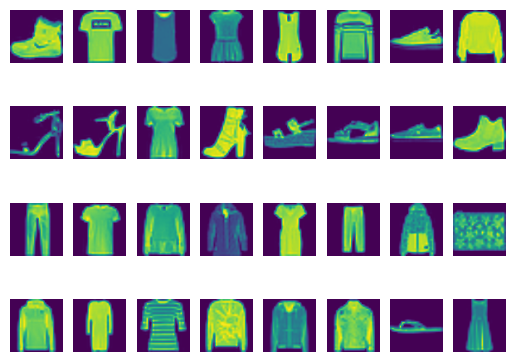

In [5]:
IMG_SIZE = 64
BATCH_SIZE = 32
LATENT_DIM = 2

transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize(IMG_SIZE),
        v2.ToDtype(torch.float32),
        # v2.Normalize(mean=[0], std=[1]),
        v2.Lambda(lambda x: x / 255),
    ]
)

dataset = datasets.FashionMNIST(
    root="./",
    transform=transform
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
)

imgs, _ = next(iter(dataloader))
imgs = imgs.squeeze()
fig, axes = plt.subplots(nrows=4, ncols=8)
for ax, img in zip(axes.flat, imgs):
    ax.imshow(img)
    ax.axis("off")
plt.show()

# Энкодер

In [3]:
# Не полный - получение мат. ожиданий и дисперсий будет выполнено в самом VAE

encoder = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),

    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    
    nn.Flatten(),
    
    nn.Linear(64 * 16 * 16, 16),
    nn.ReLU(),
    
)

In [44]:
# encoder
print(summary(encoder, (1, 64, 64)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
              ReLU-4           [-1, 64, 16, 16]               0
           Flatten-5                [-1, 16384]               0
            Linear-6                   [-1, 16]         262,160
              ReLU-7                   [-1, 16]               0
Total params: 280,976
Trainable params: 280,976
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.88
Params size (MB): 1.07
Estimated Total Size (MB): 1.96
----------------------------------------------------------------
None


# Декодер

In [6]:
class Reshape(nn.Module):
    """
    В pytorch отсутствует слой Reshape (как в keras),
    поэтому, его необходимо определить самостоятельно
    """
    def __init__(self, size):
        super().__init__()
        self.size = size

    def forward(self, x):
        # print(self.size)
        # print(x.size())
        # print(torch.rand(self.size).size())
        return x.view(-1, *self.size)


decoder = nn.Sequential(
    nn.Linear(LATENT_DIM, 64 * 8 * 8),
    nn.ReLU(),
    Reshape((64, 8, 8)),
    
    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
    nn.ReLU(),

    nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
    nn.ReLU(),
    
    nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
    nn.ReLU(),

    nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=1),
    nn.Sigmoid(),
)

In [8]:
print(summary(decoder, ( 2,)))

(64, 8, 8)
torch.Size([2, 4096])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]          12,288
              ReLU-2                 [-1, 4096]               0
           Reshape-3             [-1, 64, 8, 8]               0
   ConvTranspose2d-4           [-1, 32, 16, 16]          32,800
              ReLU-5           [-1, 32, 16, 16]               0
   ConvTranspose2d-6           [-1, 16, 32, 32]           8,208
              ReLU-7           [-1, 16, 32, 32]               0
   ConvTranspose2d-8            [-1, 8, 64, 64]           2,056
              ReLU-9            [-1, 8, 64, 64]               0
           Conv2d-10            [-1, 1, 64, 64]              73
          Sigmoid-11            [-1, 1, 64, 64]               0
Total params: 55,425
Trainable params: 55,425
Non-trainable params: 0
----------------------------------------------------------------

# VAE

In [7]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.enc_mean = nn.Linear(16, LATENT_DIM)
        self.enc_log_var = nn.Linear(16, LATENT_DIM)

    def encode(self, x):
        enc_output = self.encoder(x)
        z_mean = self.enc_mean(enc_output)
        z_log_var = self.enc_log_var(enc_output)
        return z_mean, z_log_var

    def decode(self, z_mean, z_log_var):
        # reparametrization
        std_devs = torch.pow(2, z_log_var) **.5
        aux = MultivariateNormal(torch.zeros(LATENT_DIM,),
                                 torch.eye(LATENT_DIM)).sample()
        aux = aux.to(device)
        sample = z_mean + aux * std_devs
        return self.decoder(sample)
    
    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        output = self.decode(z_mean, z_log_var)
        return output, z_mean, z_log_var

    def reconstruct(self, sample):
        return self.decoder(sample)    

## Подсчет потерь

In [61]:
def compute_loss(input_img, reconstructed_img, z_mean, z_log_var):
    # KL divergence
    kl_loss = -.5 * torch.sum(1 + z_log_var - 
                              z_mean**2 - torch.pow(2, z_log_var)) 
    # BCE loss (потери при создании изображения декодером)
    construct_loss = bceloss(reconstructed_img, input_img)
    return kl_loss + construct_loss

# Обучение модели

In [62]:
# vae = VAE(encoder, decoder).to(device)
vae = VAE(encoder, decoder)
vae.to(device)

def train(dataloader, epochs=10):
    vae.train()
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)
    for epoch in range(1, epochs + 1):
        # for bathc_idx, (data, _) in enumerate(dataloader):
        for data, _ in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            # data = data.view((-1, IMG_SIZE * IMG_SIZE))
            output, z_mean, z_log_var = vae(data) # для батча
            loss = compute_loss(data, output,
                                z_mean, z_log_var)
            loss.backward()
            optimizer.step()
        print(f"epoch {epoch} / {epochs}; loss {loss.item()}") 
    if not p.exists("./weights"):
        os.mkdir("./weights")
    torch.save(vae.state_dict(), "./weights/vae.pt")
    torch.save(decoder.state_dict(), "./weights/decoder.pt")


In [63]:
train(dataloader, epochs=10)

epoch 1 / 10; loss 48330.171875
epoch 2 / 10; loss 47434.1875
epoch 3 / 10; loss 47119.59375
epoch 4 / 10; loss 47306.1953125
epoch 5 / 10; loss 47292.30078125
epoch 6 / 10; loss 48597.42578125
epoch 7 / 10; loss 46974.91796875
epoch 8 / 10; loss 46983.8046875
epoch 9 / 10; loss 46907.0390625
epoch 10 / 10; loss 46793.17578125


# Визуализация результатов

In [21]:
def test():
    dist = MultivariateNormal(torch.zeros(LATENT_DIM),
                             torch.eye(LATENT_DIM))
    vae = VAE(encoder, decoder)
    vae.load_state_dict(torch.load("./weights/vae.pt", weights_only=True))
    vae.eval()
    outputs = []

    for i in range(BATCH_SIZE):
        sample = dist.sample()
        outputs.append(vae
                       .reconstruct(sample)
                       .view((64, 64))
                       .detach())
    outputs = torch.stack(outputs)
    return outputs

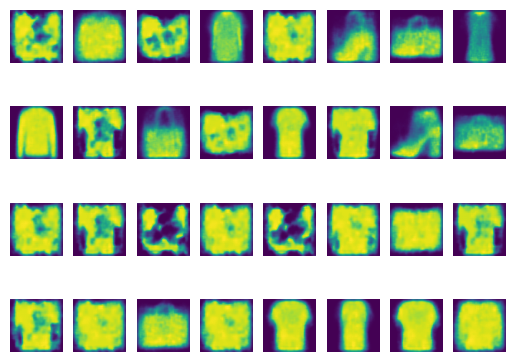

In [23]:
outputs = test()

fig, axes = plt.subplots(nrows=4, ncols=8)
for ax, img in zip(axes.flat, outputs):
    ax.imshow(img)
    ax.axis("off")
plt.show()